In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = False

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [6]:
epoch = 250

In [7]:
root = 'src/data/dyn_pid_controller/explo'

In [8]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.06744875, -0.03263669], dtype=float32), array([-0.04348378,  0.0653242 ], dtype=float32), array([-0.00105075,  0.00017626], dtype=float32))
-0.00013733695751645228


<IPython.core.display.Javascript object>


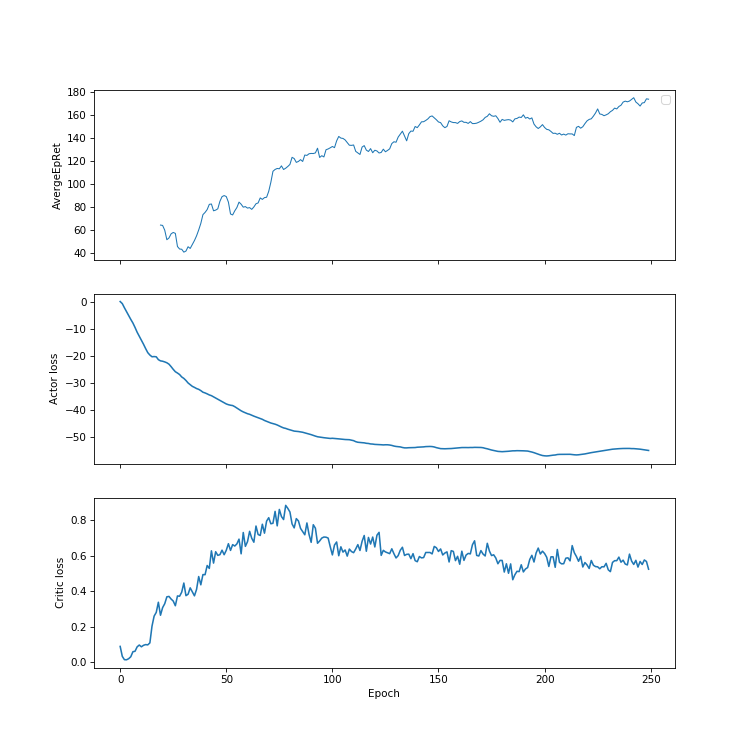

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


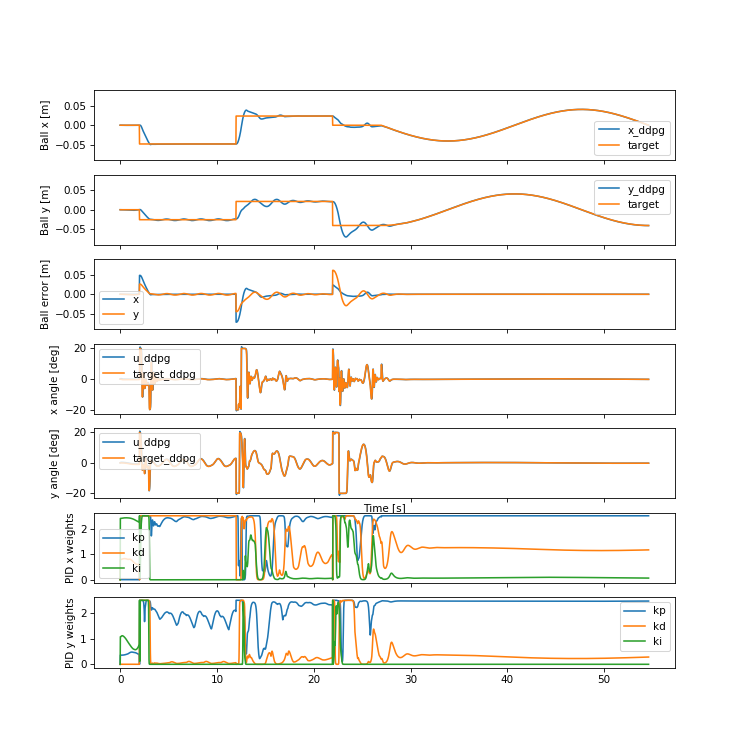

In [12]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [13]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.02304932, -0.06231852], dtype=float32), array([-0.02906715, -0.06663394], dtype=float32), array([-0.00098571,  0.00040268], dtype=float32))
-0.0005707344674130521


<IPython.core.display.Javascript object>


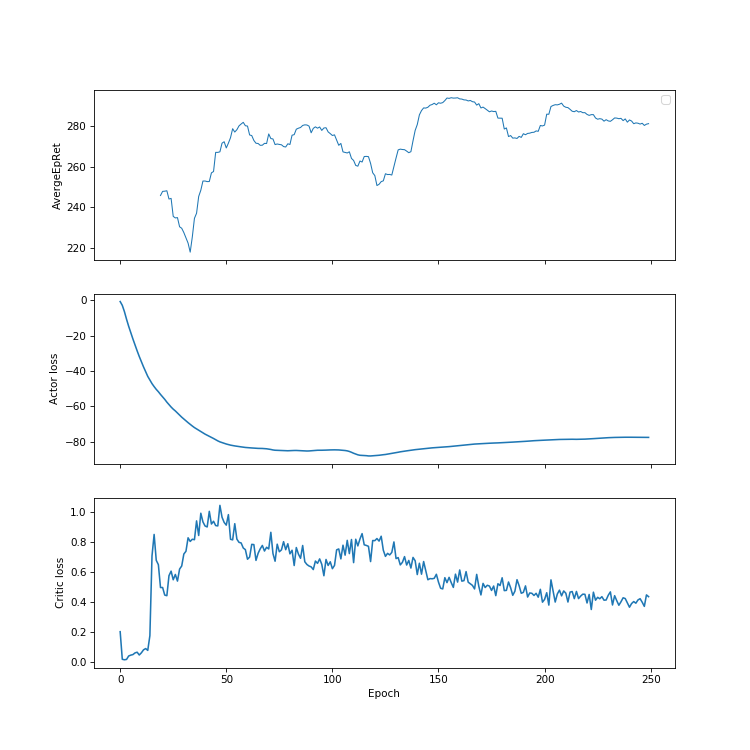

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


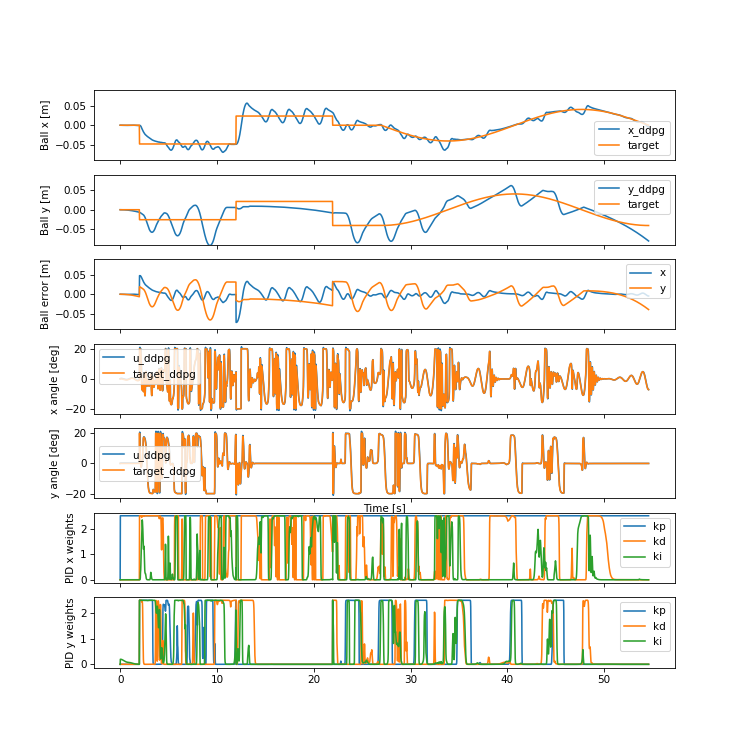

In [14]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [15]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05262008,  0.0163595 ], dtype=float32), array([-0.04268764,  0.0509874 ], dtype=float32), array([-0.00201508, -0.00280919], dtype=float32))
-0.0003189961881197567


<IPython.core.display.Javascript object>


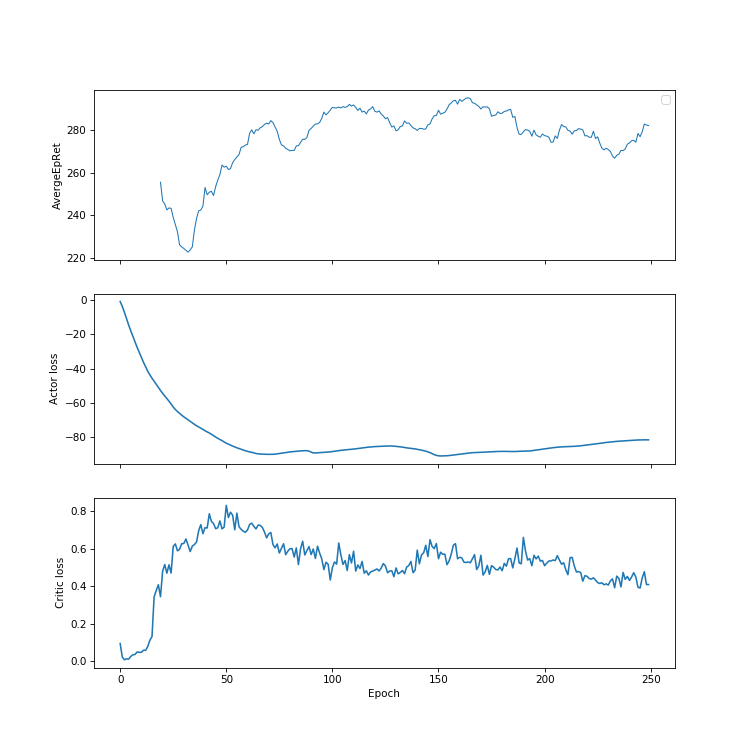

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


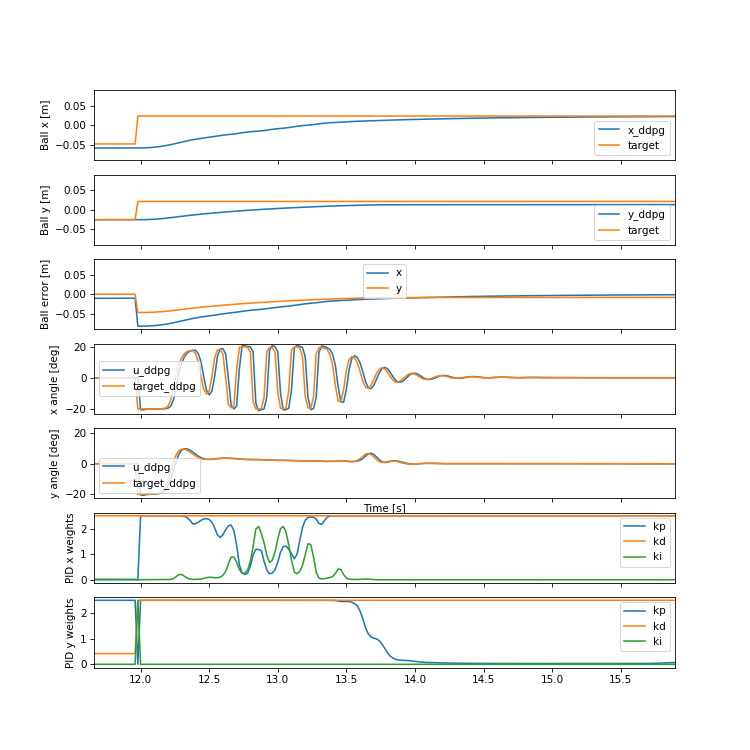

In [16]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [17]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.01253804, -0.01977232], dtype=float32), array([0.06088159, 0.04149311], dtype=float32), array([-1.3439907e-03, -3.6516154e-05], dtype=float32))
-0.00024079294076927702


<IPython.core.display.Javascript object>


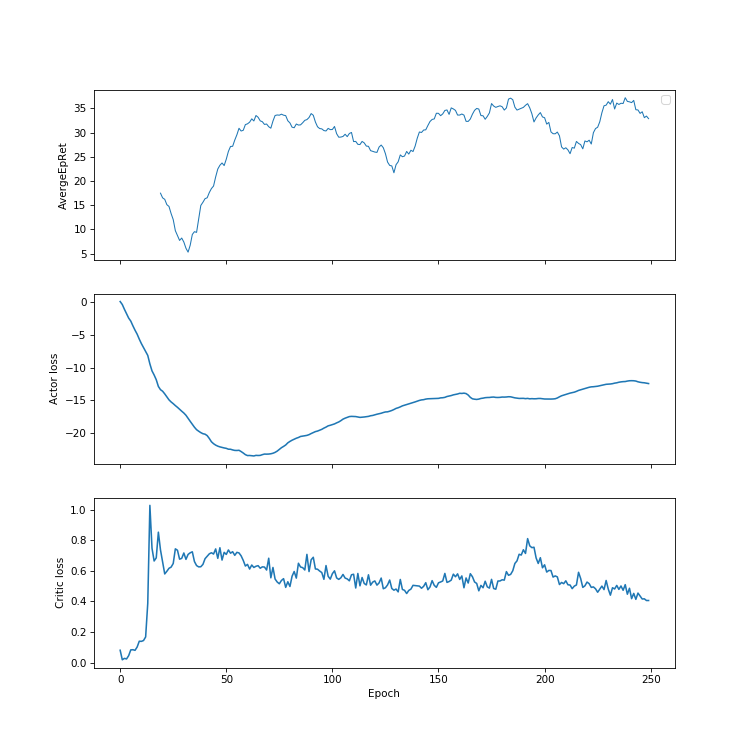

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


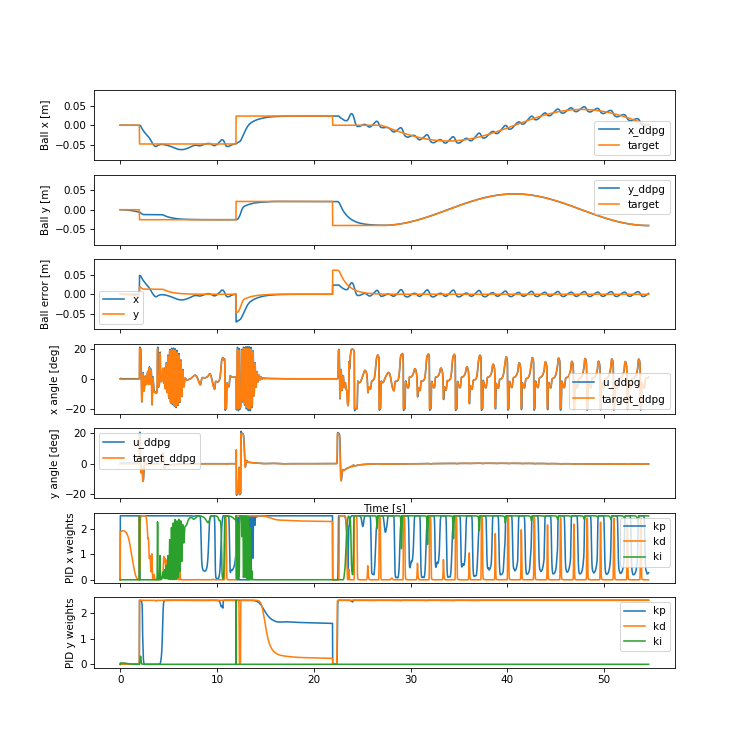

In [18]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [19]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='le0.3_[100]_signmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.07175328, -0.03993138], dtype=float32), array([0.01704949, 0.00271374], dtype=float32), array([-0.0014413 ,  0.00136733], dtype=float32))
-0.00017409230361428073


<IPython.core.display.Javascript object>


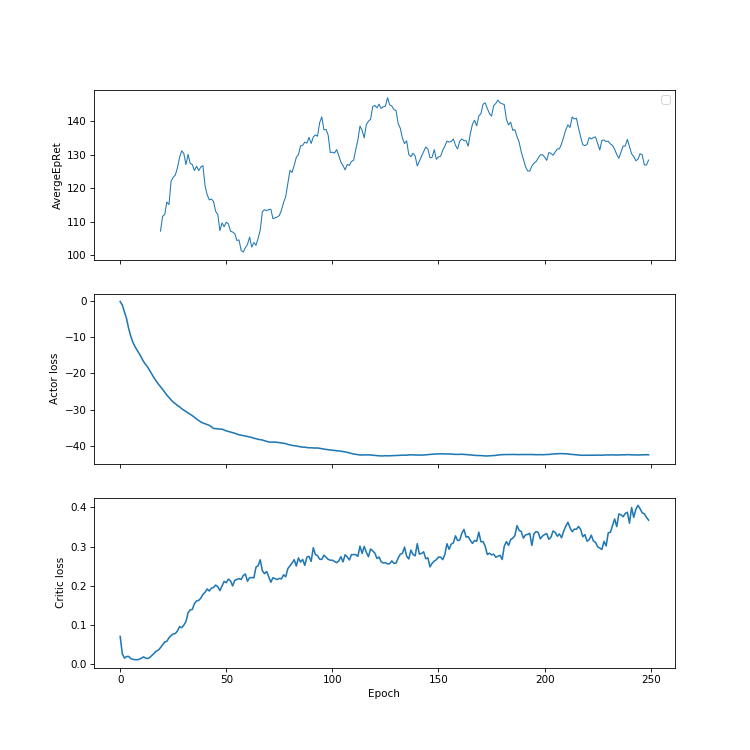

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


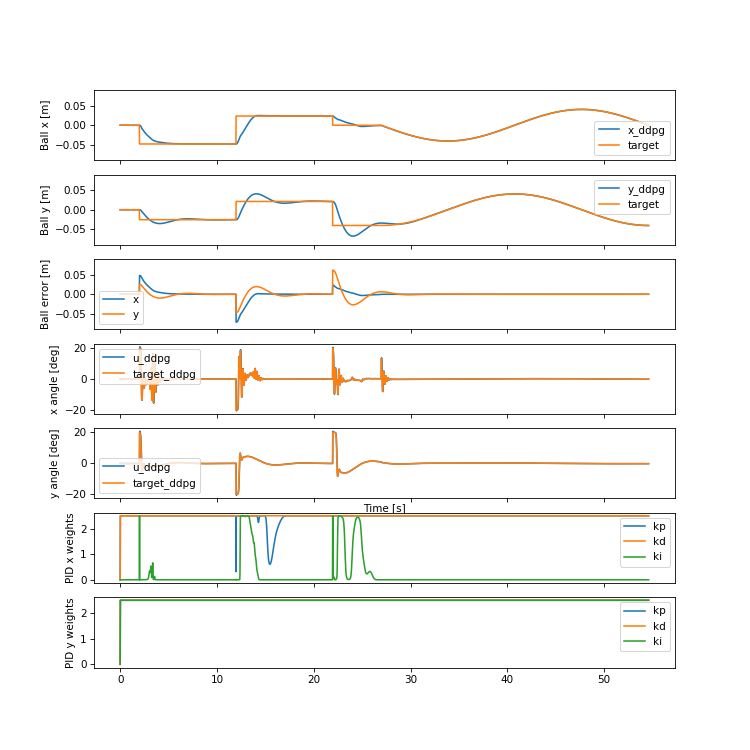

In [20]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [21]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pe1_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03316529, 0.01634643], dtype=float32), array([ 0.03939973, -0.00992311], dtype=float32), array([0.00085198, 0.00231059], dtype=float32))
-0.0006221030751066166


<IPython.core.display.Javascript object>


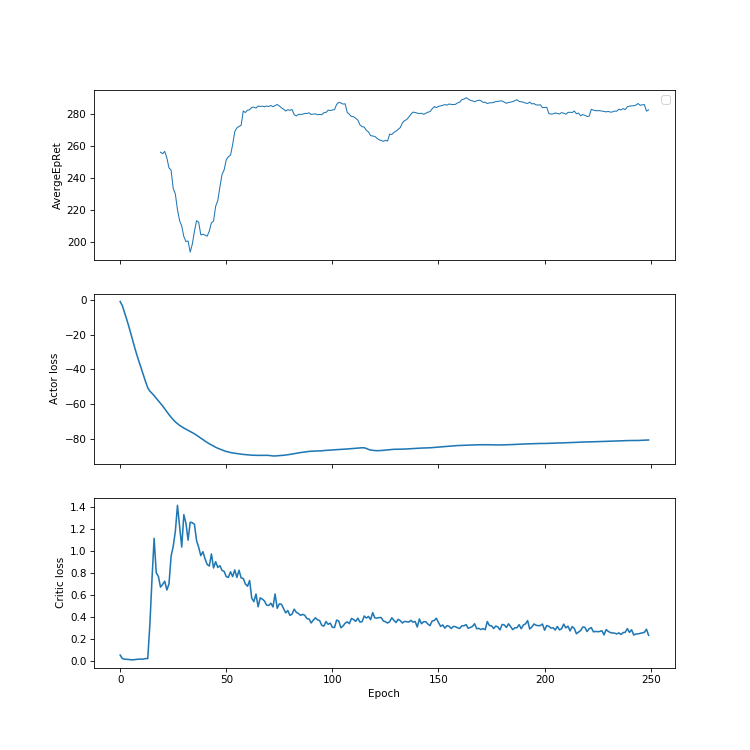

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


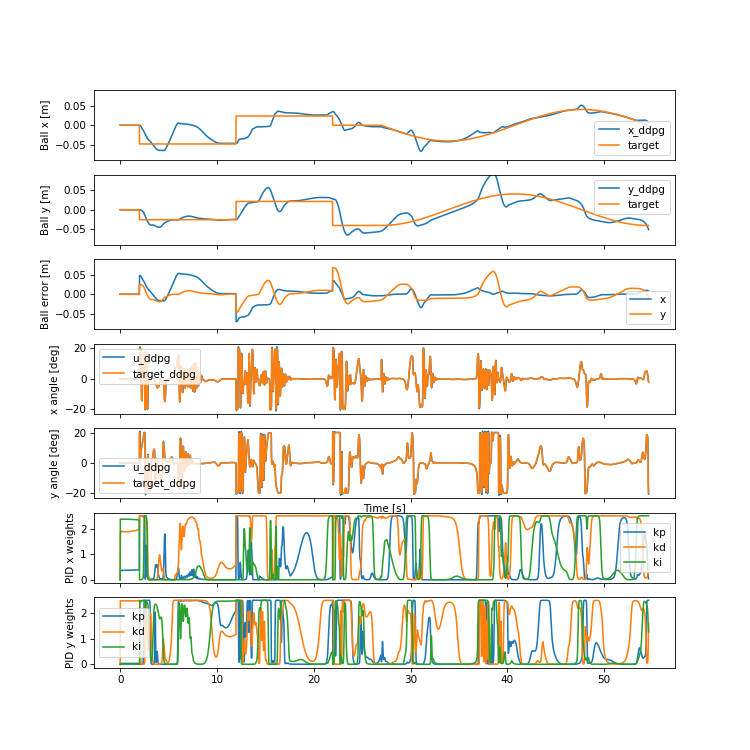

In [22]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [23]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pep0.3_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04556136, -0.02121168], dtype=float32), array([0.02697228, 0.05979375], dtype=float32), array([0.00153937, 0.00208132], dtype=float32))
-0.00035997305952652523


<IPython.core.display.Javascript object>


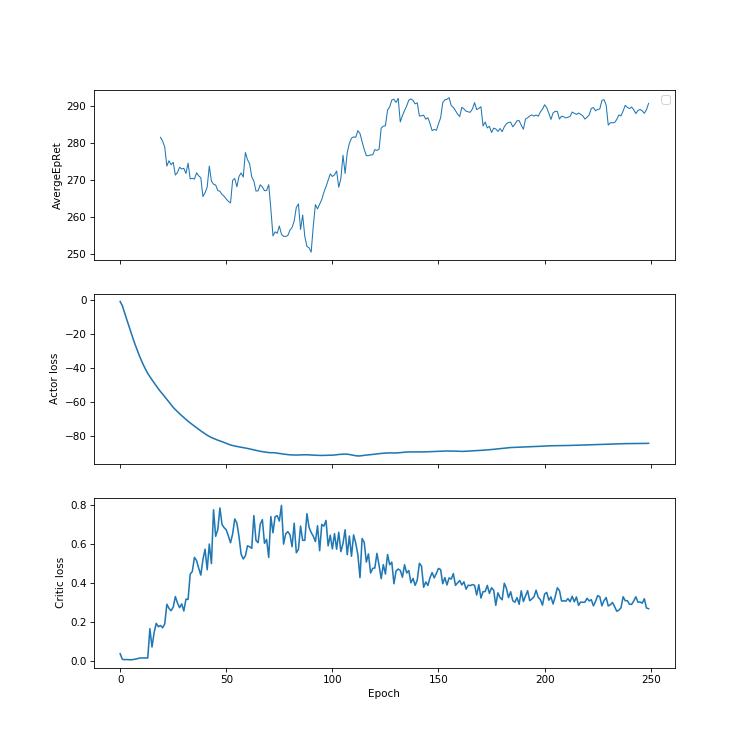

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


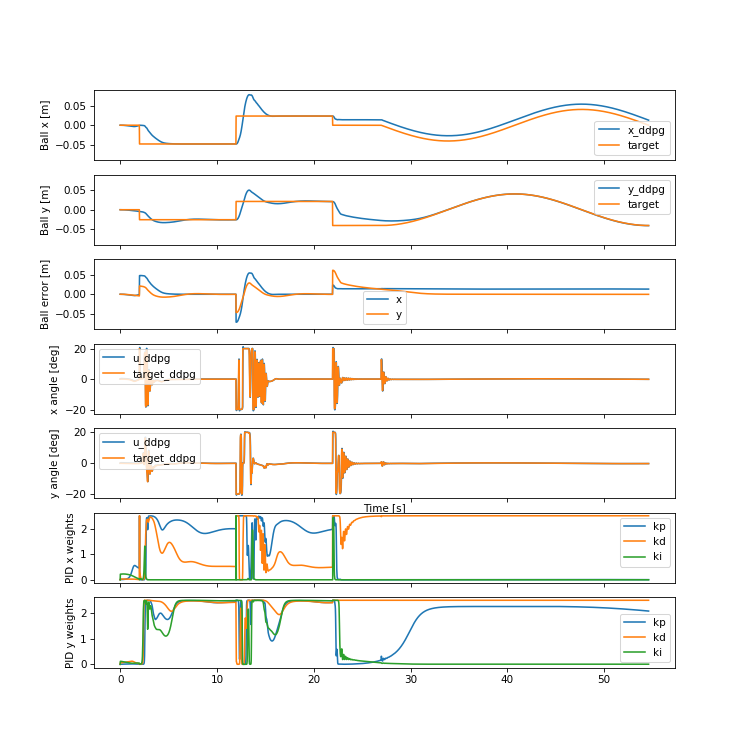

In [24]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [25]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.01290731, 0.06802662], dtype=float32), array([0.06852213, 0.0533459 ], dtype=float32), array([-0.0008676 , -0.00027953], dtype=float32))
-0.00038461567486699724


<IPython.core.display.Javascript object>


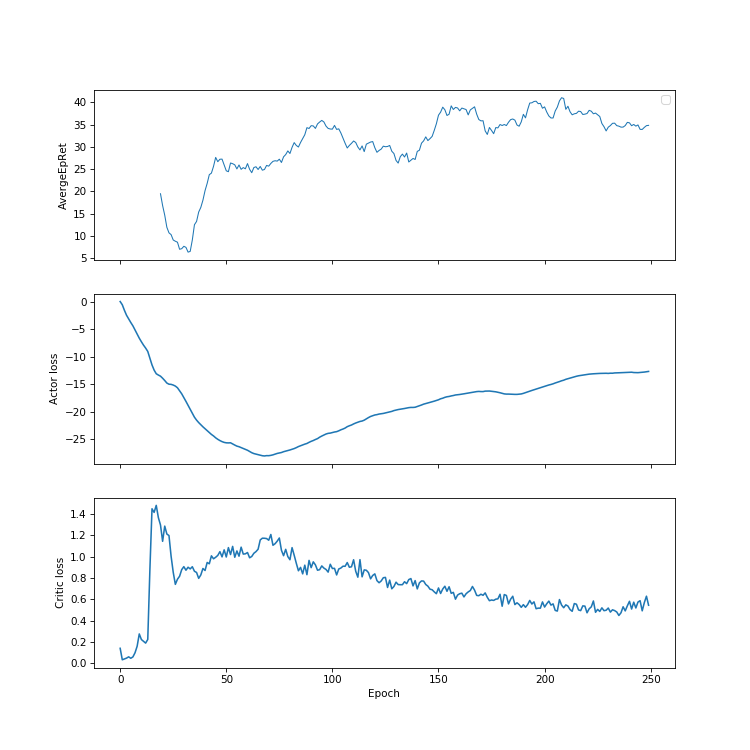

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


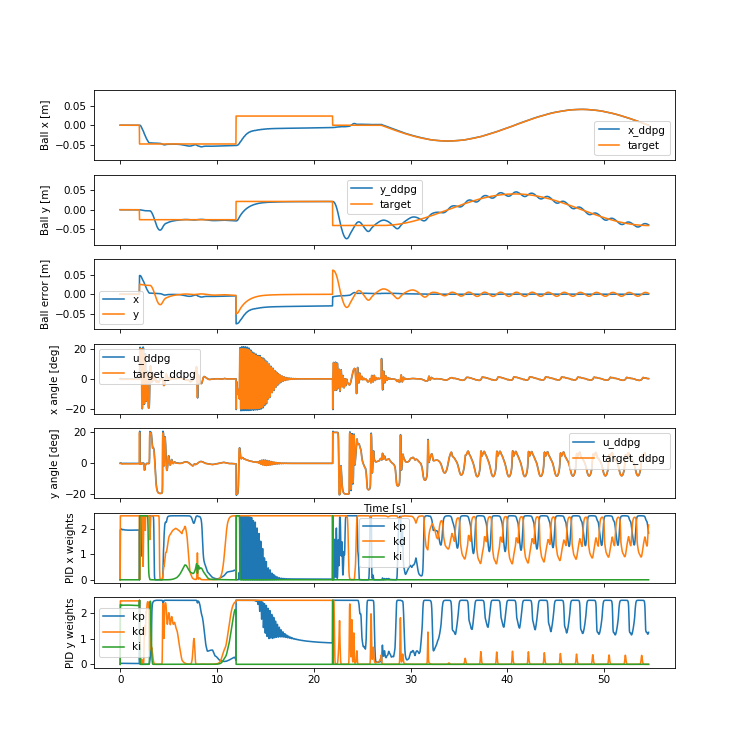

In [26]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [29]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0312682 ,  0.05640166], dtype=float32), array([-0.03273878, -0.06890063], dtype=float32), array([-0.00298438,  0.00259704], dtype=float32))
-0.00024082541658735355


<IPython.core.display.Javascript object>


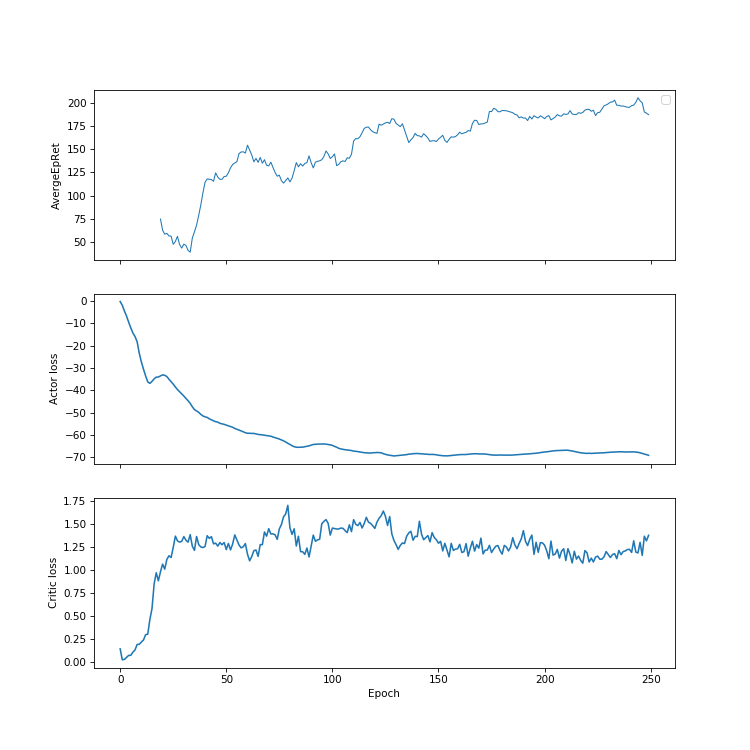

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


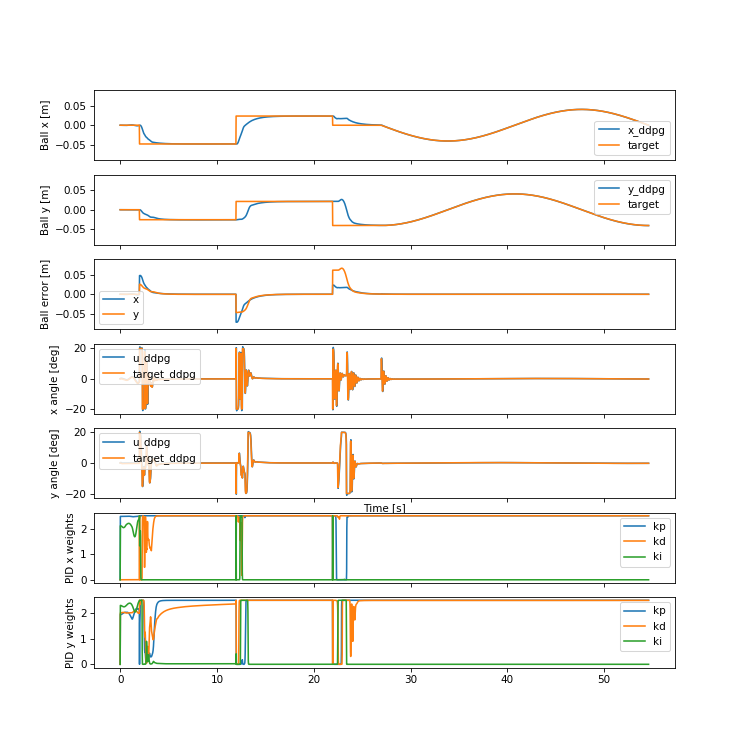

In [30]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [31]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1.4
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1.4_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05812047,  0.03285893], dtype=float32), array([-0.06119351,  0.01269067], dtype=float32), array([ 0.00025466, -0.00281484], dtype=float32))
-0.00048484329312795273


<IPython.core.display.Javascript object>


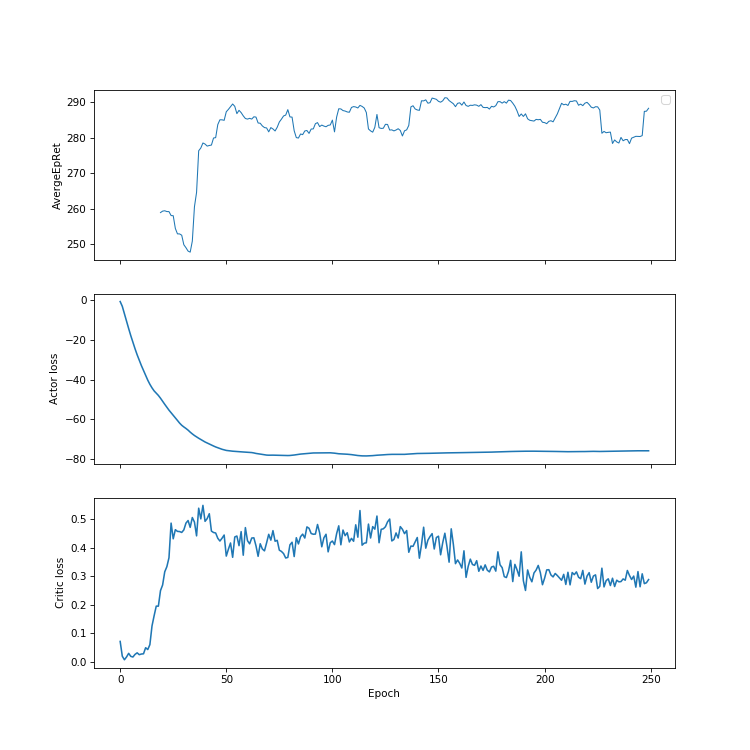

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


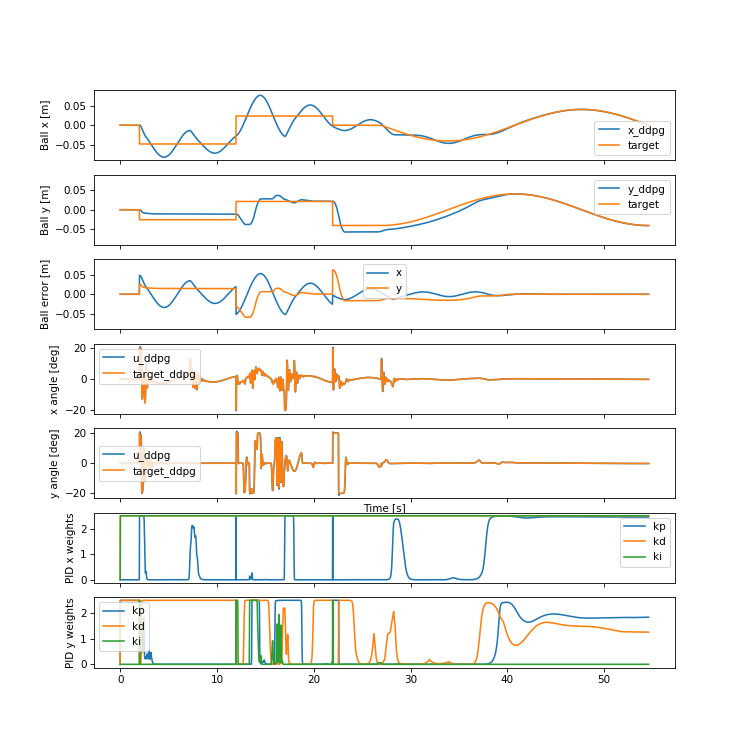

In [32]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [33]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03029708, -0.02358032], dtype=float32), array([0.05834378, 0.01042326], dtype=float32), array([-0.00291259,  0.00101174], dtype=float32))
-0.0003211437514726128


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


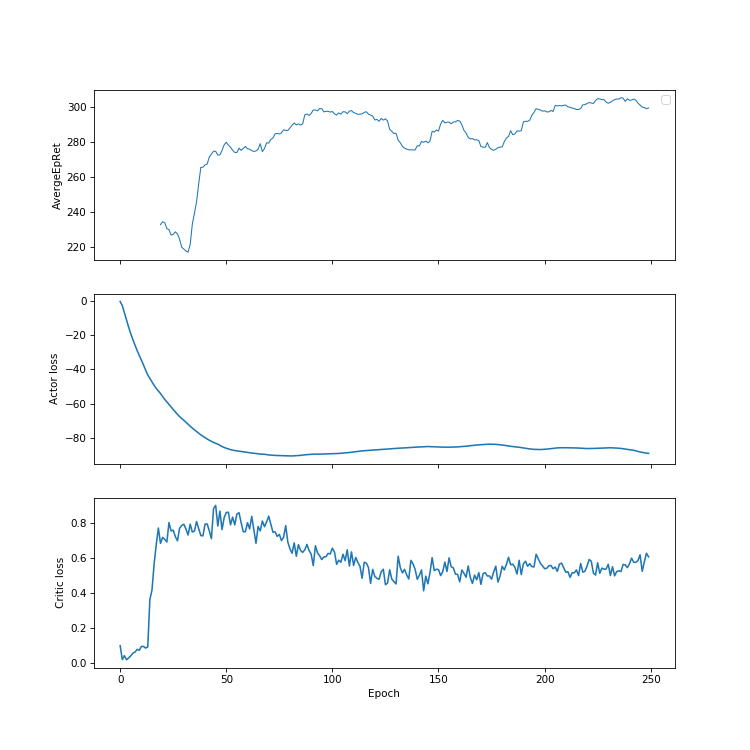

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


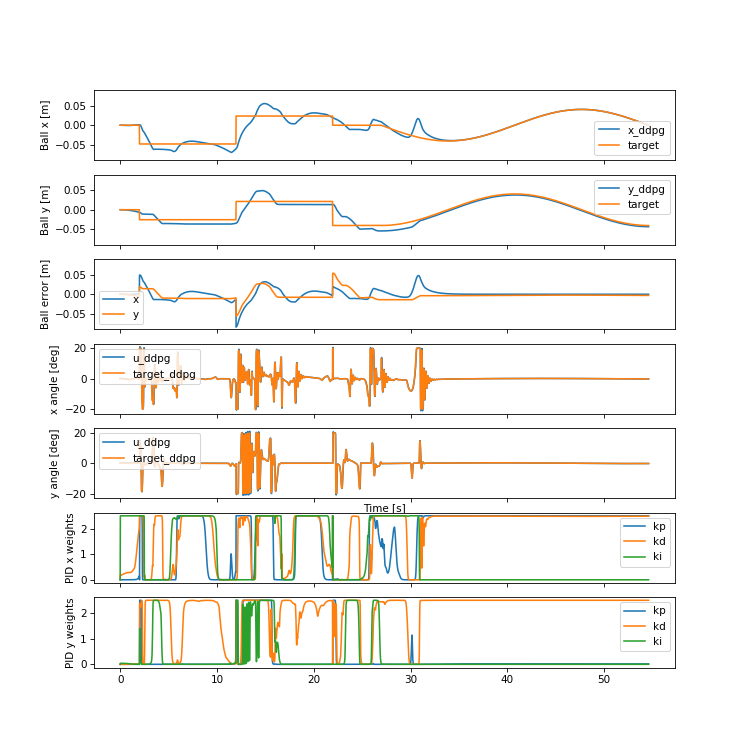

In [34]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [35]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 5
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de5_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0653865 , -0.02674853], dtype=float32), array([-0.0561039 , -0.00588562], dtype=float32), array([-0.00140488, -0.00108034], dtype=float32))
-0.00024190575722608286


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


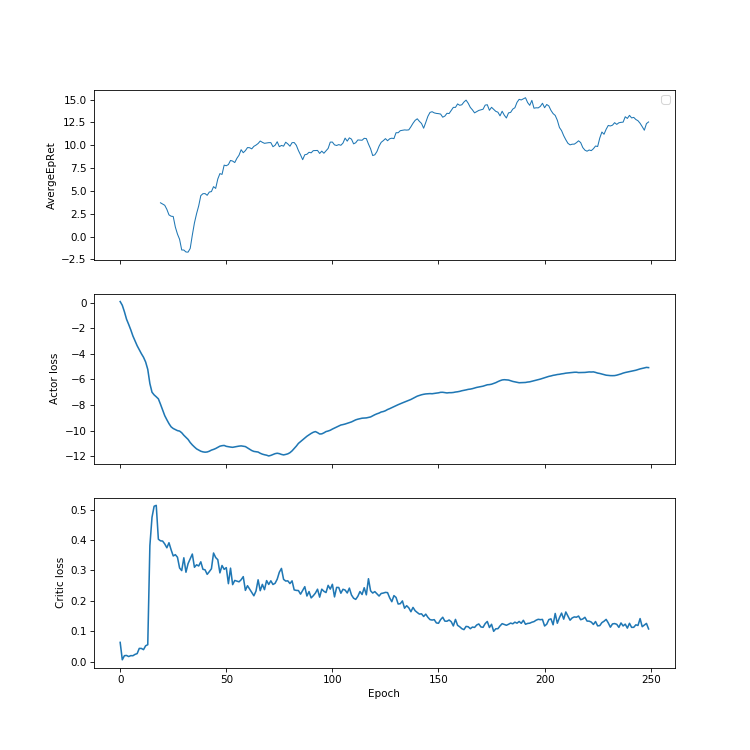

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


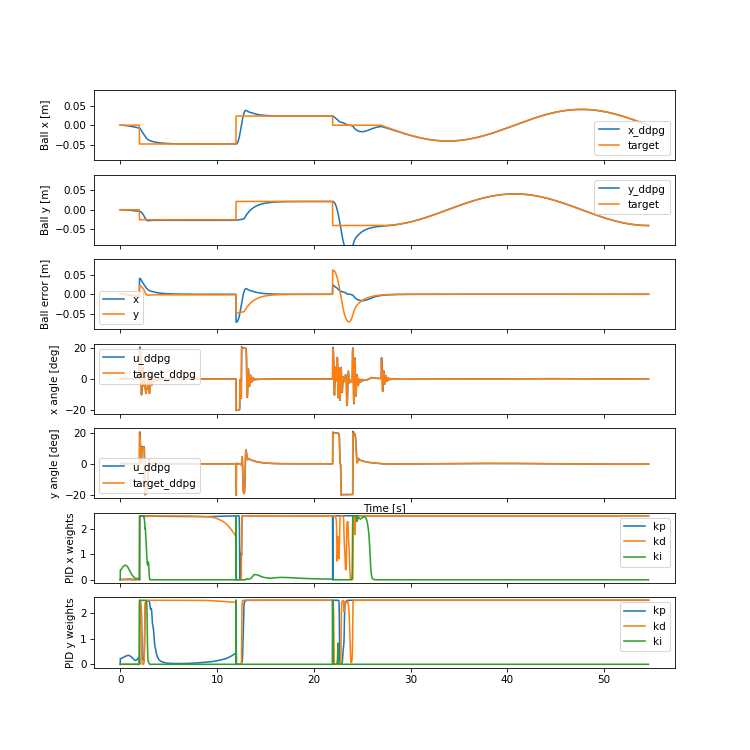

In [37]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [38]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='le0.3_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.05425319, 0.03079017], dtype=float32), array([-0.00711032, -0.0083046 ], dtype=float32), array([-0.0018617 ,  0.00053188], dtype=float32))
-0.00016199687892106361


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


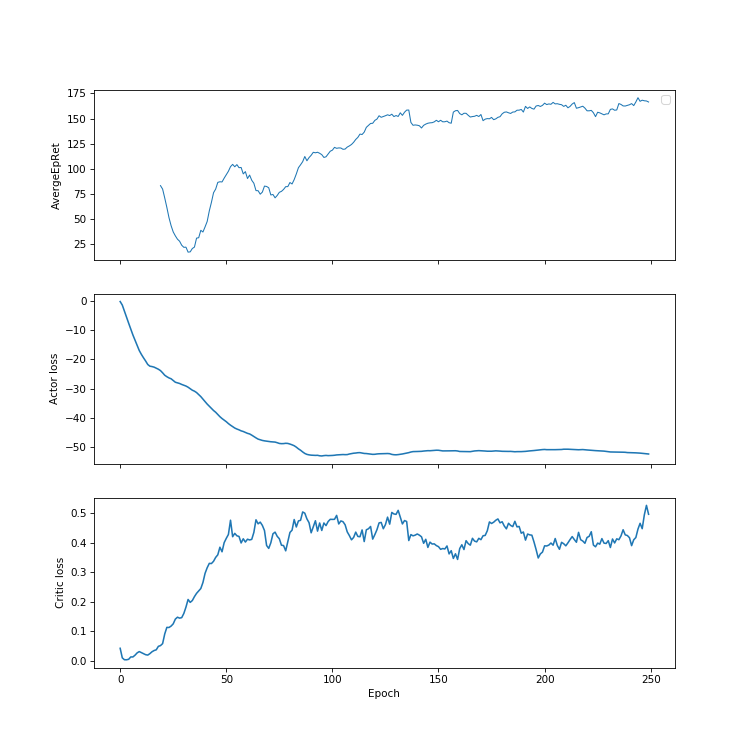

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


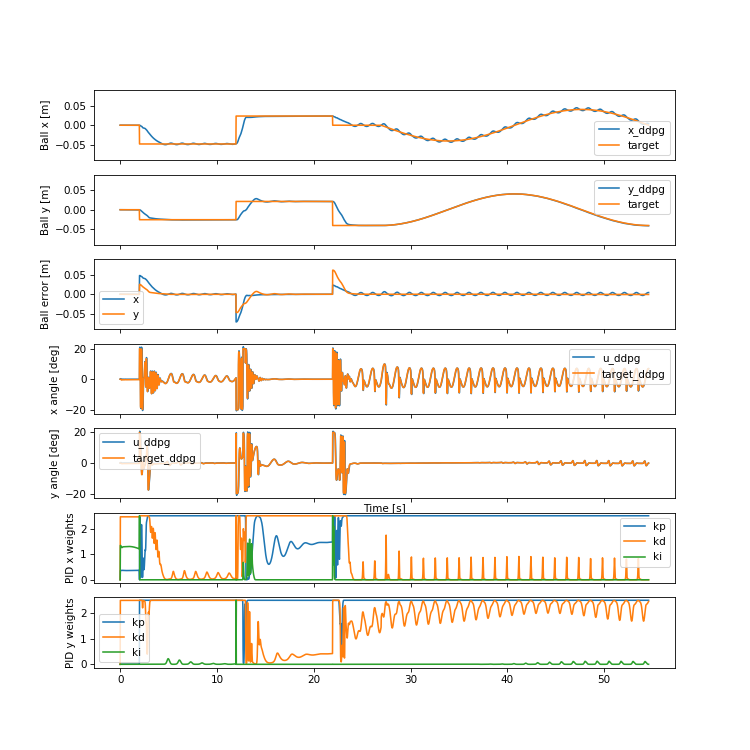

In [39]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [40]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='pe1_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.03577707, -0.03569939], dtype=float32), array([0.0703152 , 0.00756357], dtype=float32), array([0.00168556, 0.00117506], dtype=float32))
-0.00031145055063507146


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


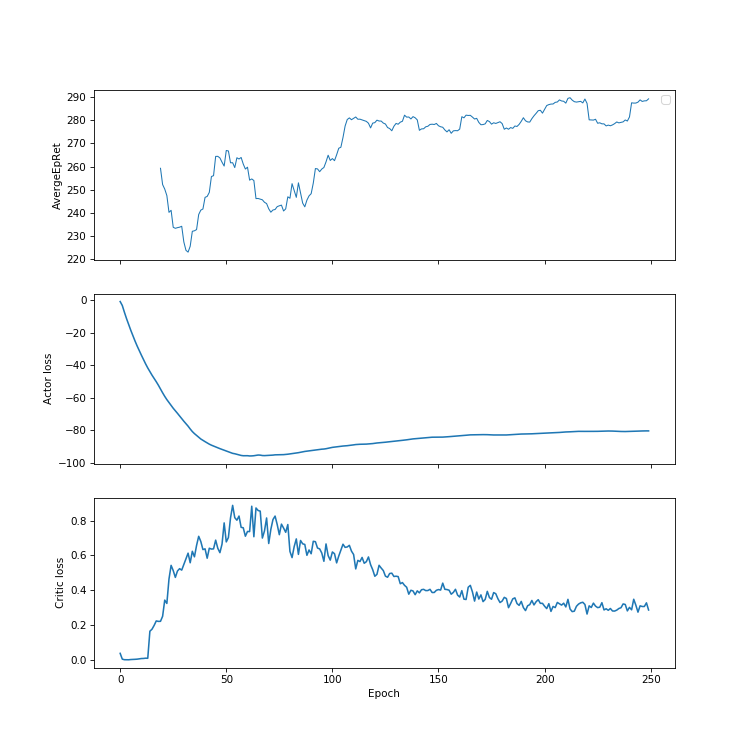

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


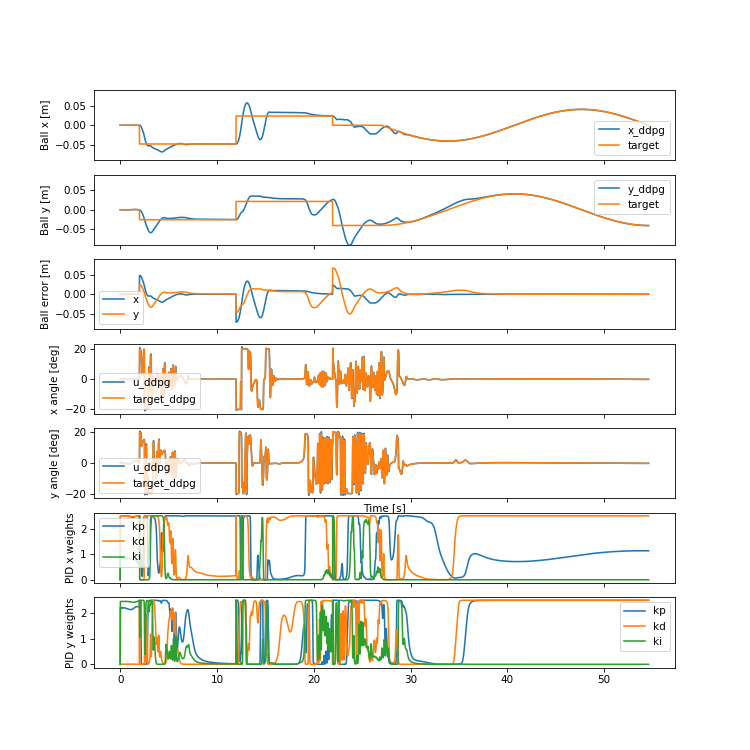

In [41]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [42]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='pep0.3_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00765409,  0.06069467], dtype=float32), array([ 0.01487083, -0.04918933], dtype=float32), array([-0.00125245,  0.00242644], dtype=float32))
-0.0003186401912213778


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


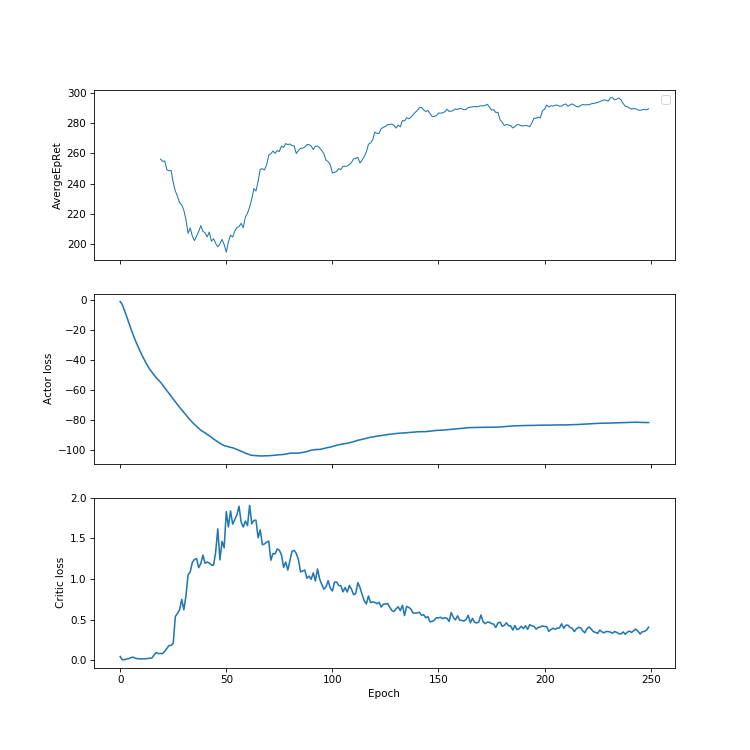

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


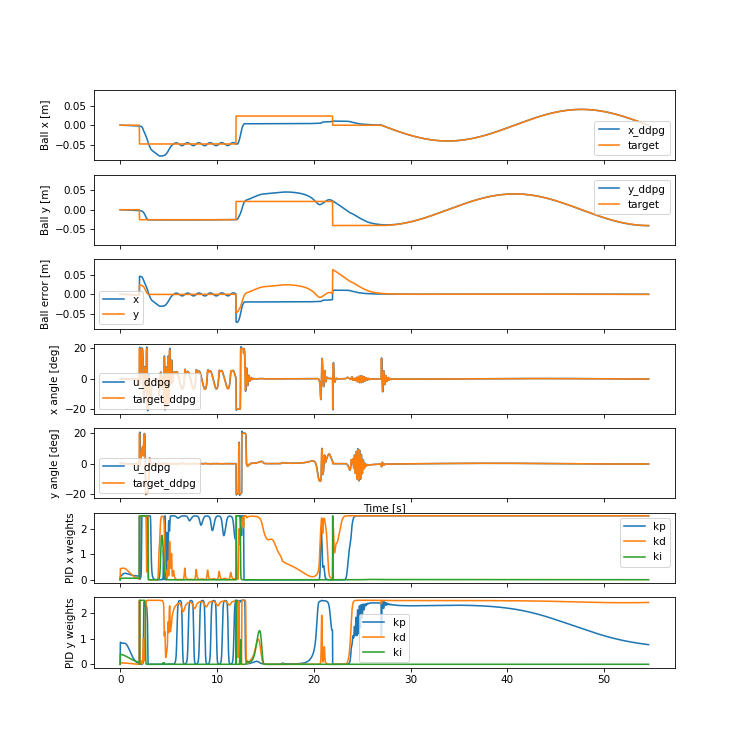

In [43]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [48]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='de15_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00373839,  0.05592158], dtype=float32), array([ 0.02450035, -0.06809094], dtype=float32), array([ 0.00235041, -0.00291907], dtype=float32))
-0.0005630869775173455


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


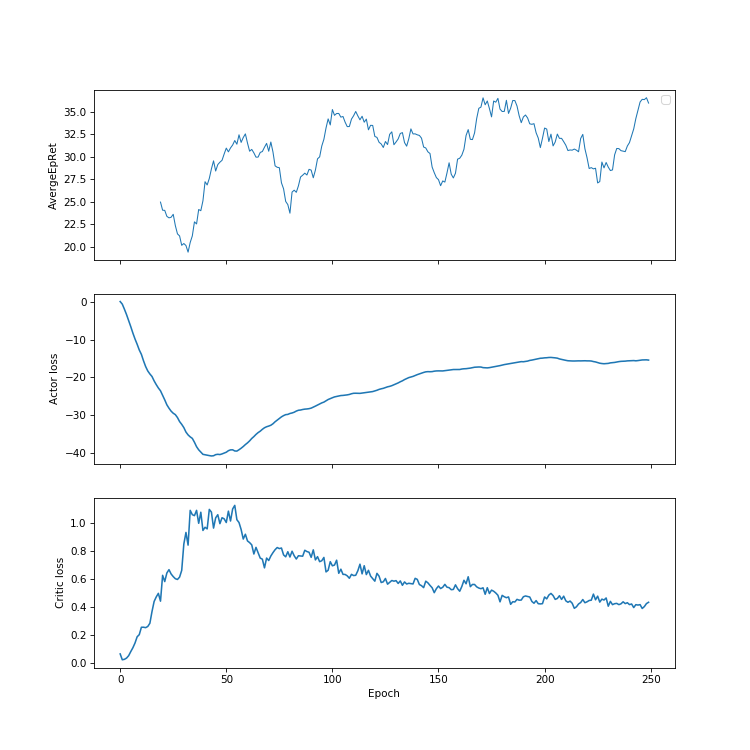

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


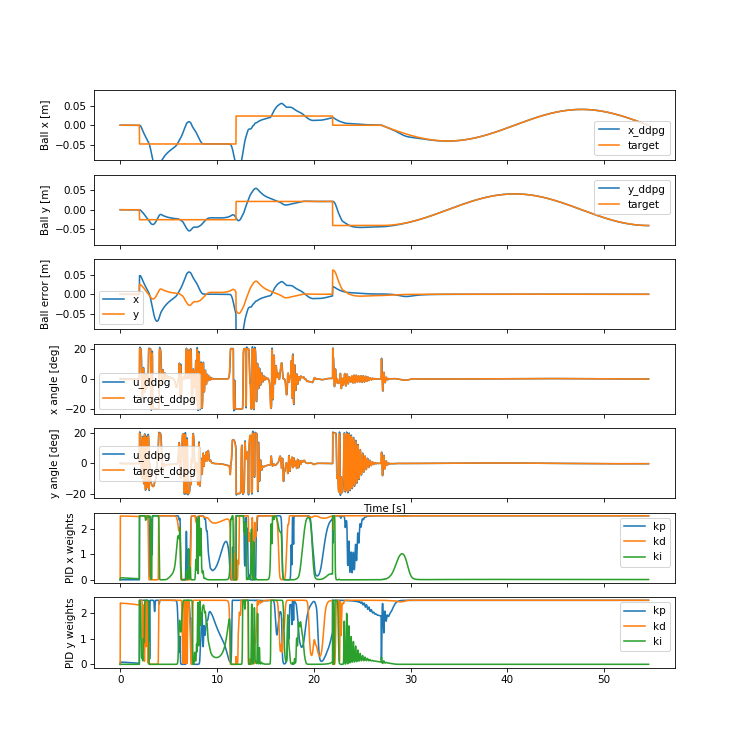

In [49]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [52]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100, 50]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100, 50]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03359334, 0.04217907], dtype=float32), array([ 0.02262251, -0.03532873], dtype=float32), array([ 0.00115804, -0.00215583], dtype=float32))
-0.00013962961847682938


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


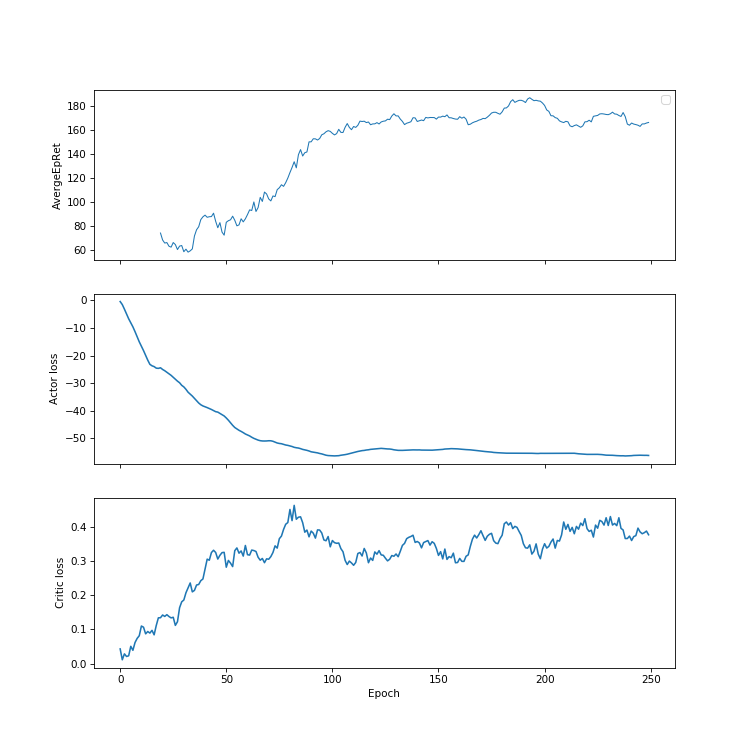

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


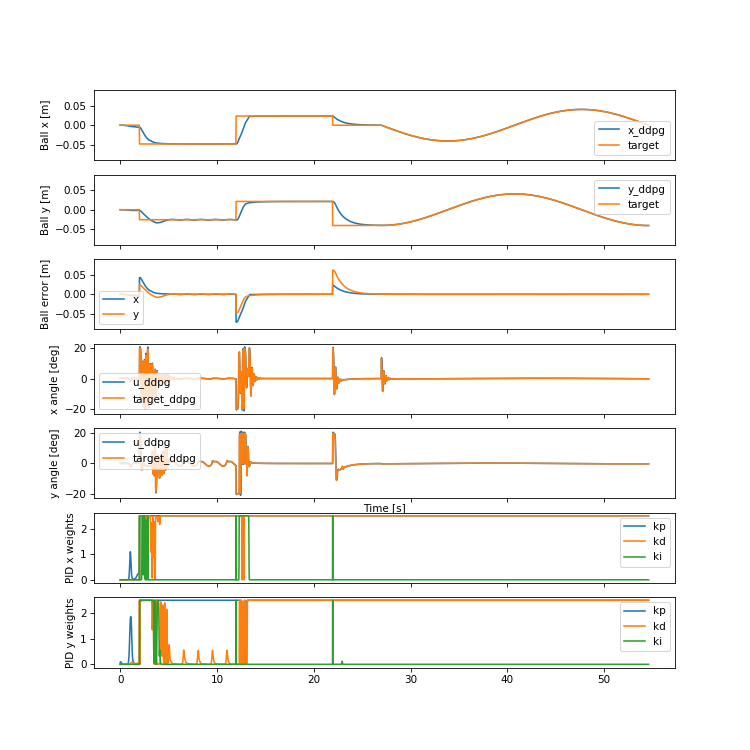

In [53]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [54]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100, 75]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100, 75]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.06711907, 0.04784623], dtype=float32), array([-0.01079832, -0.05809857], dtype=float32), array([ 0.00013647, -0.00105607], dtype=float32))
-0.0003180209280188914


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


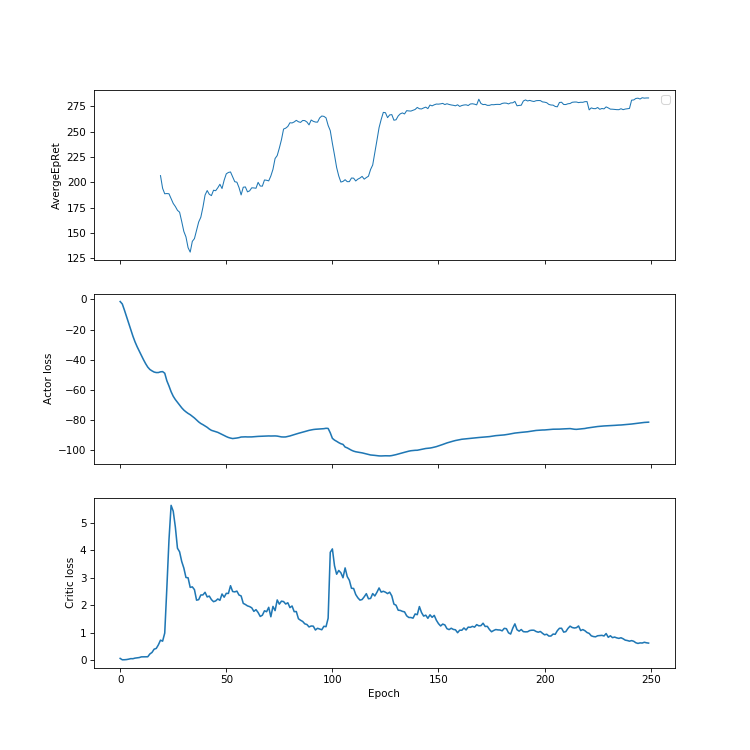

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


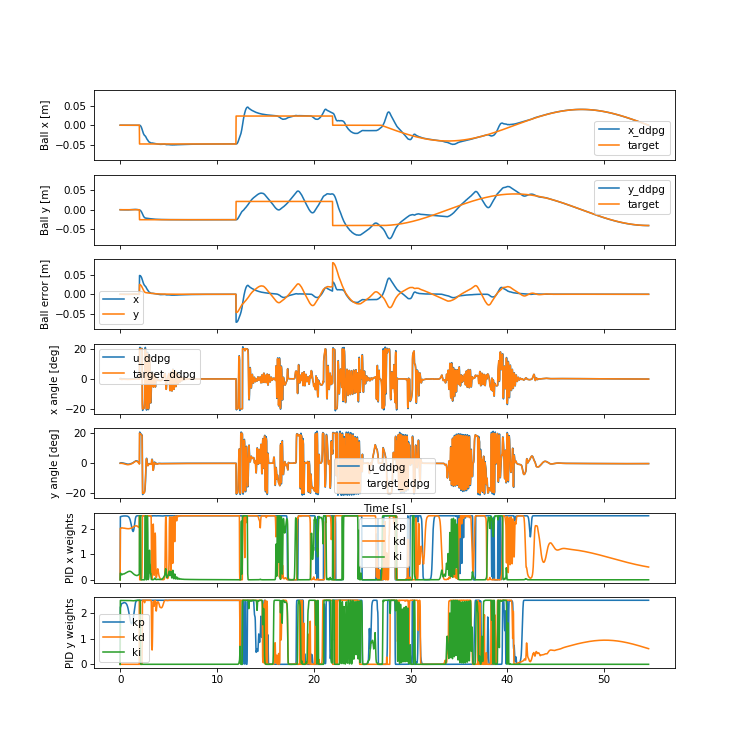

In [55]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [56]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [150, 75]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[150, 75]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.06112725, -0.04454582], dtype=float32), array([-0.01148351,  0.04807443], dtype=float32), array([-0.00012153, -0.00271462], dtype=float32))
-0.0006004154753709533


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


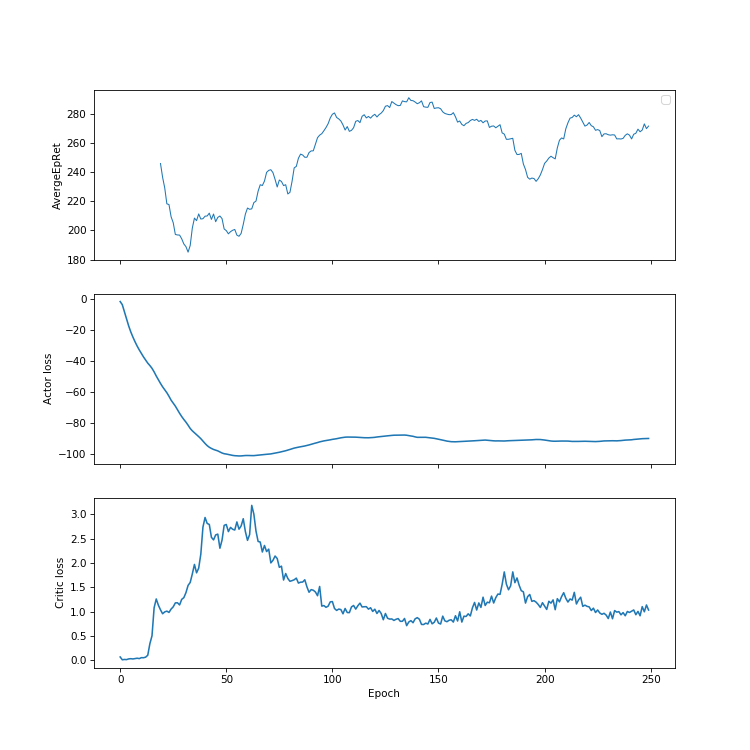

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


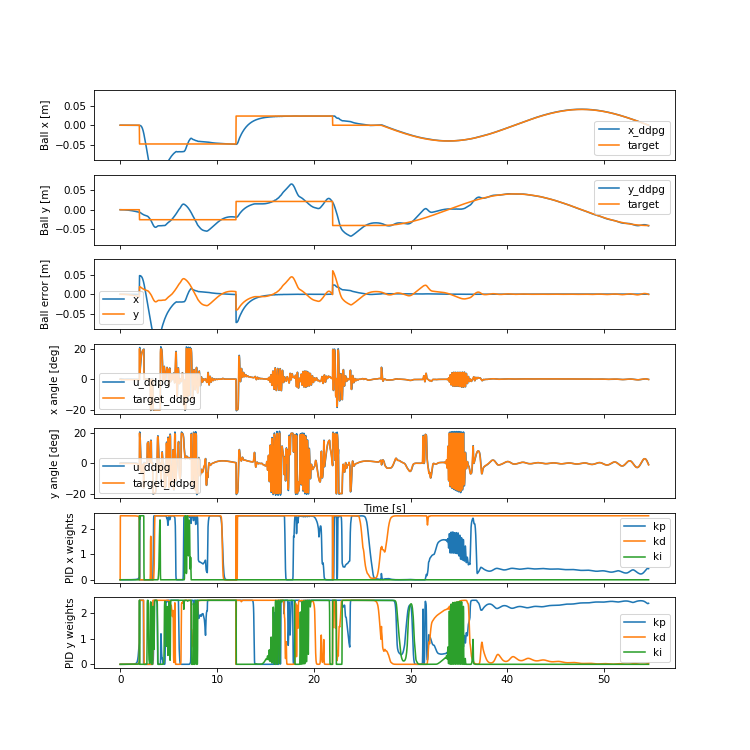

In [57]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()

In [58]:
env = BBEnvPid
ac = PidActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100, 100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100, 100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.04594594, -0.00691368], dtype=float32), array([-0.06501514, -0.07160159], dtype=float32), array([ 0.00259414, -0.0027415 ], dtype=float32))
-0.0005866993846094442


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


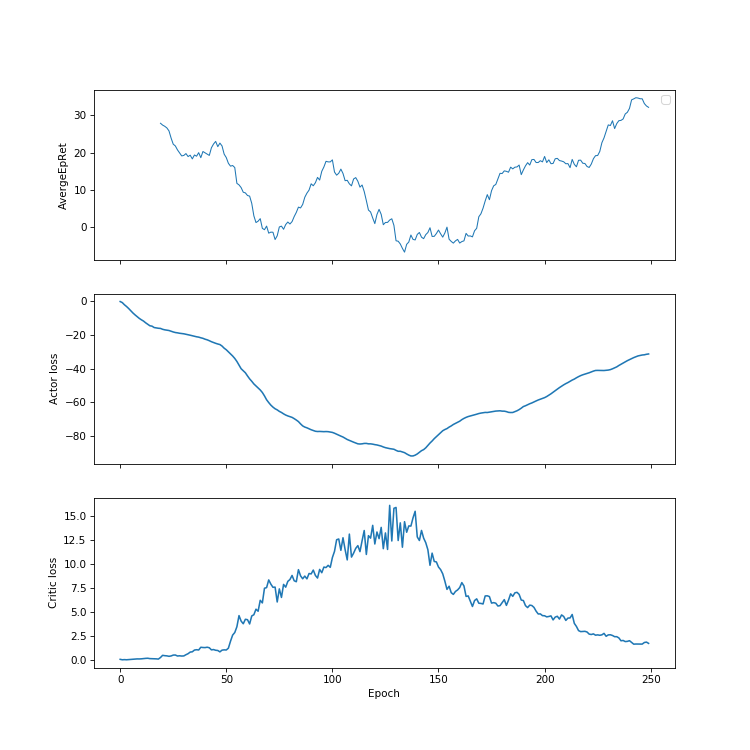

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


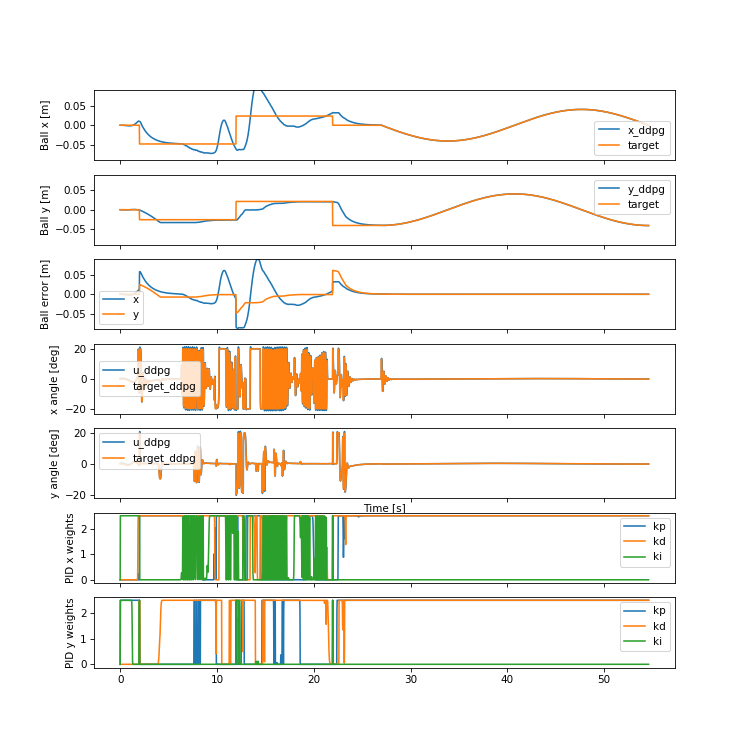

In [59]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('y angle [deg]')
axs[4].legend()

axs[5].plot(t, kp[0, :], label='kp')
axs[5].plot(t, kd[0, :], label='kd')
axs[5].plot(t, ki[0, :], label='ki')
axs[5].set_ylabel('PID x weights')
axs[5].legend()

axs[6].plot(t, kp[1, :], label='kp')
axs[6].plot(t, kd[1, :], label='kd')
axs[6].plot(t, ki[1, :], label='ki')
axs[6].set_ylabel('PID y weights')
axs[6].legend()

plt.show()